In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
from numba import njit, jit
from numba.typed import Dict, List

In [ ]:
dataset = np.load("japan.npz")
x_train = dataset["x_train"]
x_test = dataset["x_test"]
y_train = dataset["y_train"]
y_test = dataset["y_test"]

In [ ]:
x_train[:,:,:,:2] *= 6371*2*np.pi/180
x_test[:,:,:,:2] *= 6371*2*np.pi/180

In [ ]:
Nlat = y_train.shape[1]
Nlon = y_train.shape[2]
good_cells_train = np.argwhere(np.isfinite(x_train).all(axis=-1))
good_cells_test= np.argwhere(np.isfinite(x_test).all(axis=-1))

In [ ]:
df_train = pd.DataFrame()
df_train['sample'] = good_cells_train[:,0] 
df_train['lat'] = good_cells_train[:,1] 
df_train['lon'] = good_cells_train[:,2] 
df_train['label'] = y_train[good_cells_train[:,0] , good_cells_train[:,1] , good_cells_train[:,2] ]
df_train['u_n'] = x_train[good_cells_train[:,0] , good_cells_train[:,1] , good_cells_train[:,2], 0]
df_train['u_e'] = x_train[good_cells_train[:,0] , good_cells_train[:,1] , good_cells_train[:,2], 1]
df_train['u_v'] = x_train[good_cells_train[:,0] , good_cells_train[:,1] , good_cells_train[:,2], 2]

In [122]:
df_test = pd.DataFrame()
df_test['sample'] = good_cells_test[:,0] 
df_test['lat'] = good_cells_test[:,1] 
df_test['lon'] = good_cells_test[:,2] 
df_test['label'] = y_train[good_cells_test[:,0] , good_cells_test[:,1] , good_cells_test[:,2] ]
df_test['u_n'] = x_test[good_cells_test[:,0] , good_cells_test[:,1] , good_cells_test[:,2], 0]
df_test['u_e'] = x_test[good_cells_test[:,0] , good_cells_test[:,1] , good_cells_test[:,2], 1]
df_test['u_v'] = x_test[good_cells_test[:,0] , good_cells_test[:,1] , good_cells_test[:,2], 2]

In [123]:
coefs = np.ones((Nlat, Nlon, 3))*np.nan
intercept = np.ones((Nlat, Nlon))*np.nan
lrs = {}
for cell,group in df_train.groupby(["lat","lon"]):
    x_c = group[['u_n', 'u_e', 'u_v']].values
    y_c = np.heaviside(group['label'].values, 0)
    if(y_c.sum()>0):
        lr = LogisticRegression()
        lr.fit(x_c, y_c)
        coefs[cell[0], cell[1], :] = lr.coef_
        intercept[cell[0], cell[1]] = lr.intercept_
        lrs[(cell[0], cell[1])] = lr

In [ ]:
for cell,group in df_test.groupby(["lat","lon"]):
    x_c = group[['u_n', 'u_e', 'u_v']].values
    y_c = np.heaviside(group['label'].values, 0)
    if (cell[0], cell[1]) in lrs:
        

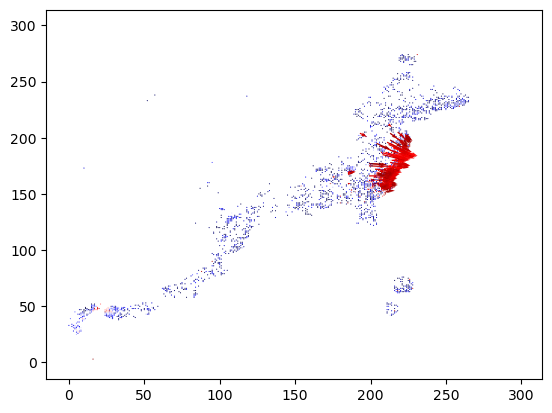

In [121]:
plt.quiver(coefs[:,:,1], coefs[:,:,0], intercept, cmap='seismic')